<a href="https://colab.research.google.com/github/maressakaren/Reconhecimento_de_emocoes_em_tweets/blob/main/modelos_pre_treinados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul  6 01:46:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install datasets
!pip install emoji
!pip install transformers
!pip install accelerate
!pip install transformers


!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.6/356.6 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.6.0-py2.py3-none-any.whl size=351311 sha256=cb14a041486292670569c845c095f06edca655148fbf48790d6691c48bd20292
  Stored in directory: /root/.cache/pip/wheels/ea/0b/64/114bc939d0083621aa41521e21be246c888260b8aa21e6c1ad
Successfully built emoji
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
import emoji
import os
import torch
import torch.nn.functional as f

from collections import Counter
from datasets import load_dataset
from unicodedata import normalize
from tqdm import tqdm
from collections import Counter
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
dataset = load_dataset("dair-ai/emotion")

dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/dair-ai___emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
n_rows = -1

tweets_train = dataset['train']['text']
tweets_validation = dataset['validation']['text']
tweets_test = dataset['test']['text']

labels_train = dataset['train']['label']
labels_validation = dataset['validation']['label']
labels_test = dataset['test']['label']

if n_rows > 0:
  tweets_train = tweets_train[:n_rows]
  tweets_validation = tweets_validation[:n_rows]
  tweets_test = tweets_test[:n_rows]

  labels_train = labels_train[:n_rows]
  labels_validation = labels_validation[:n_rows]
  labels_test = labels_test[:n_rows]

print(f'\nTrain: {len(tweets_train)}')
print(f'Validation: {len(tweets_validation)}')
print(f'Test: {len(tweets_test)}')

print(f'\n\nLabels Distribution Train: {Counter(labels_train)}')
print(f'Labels Distribution Validation: {Counter(labels_validation)}')
print(f'Labels Distribution Test: {Counter(labels_test)}')

print(f'\n\nRaw Tweet Train: {tweets_train[0]}')
print(f'Raw Tweet Validation: {tweets_validation[0]}')
print(f'Raw Tweet Test: {tweets_test[0]}')


Train: 16000
Validation: 2000
Test: 2000


Labels Distribution Train: Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
Labels Distribution Validation: Counter({1: 704, 0: 550, 3: 275, 4: 212, 2: 178, 5: 81})
Labels Distribution Test: Counter({1: 695, 0: 581, 3: 275, 4: 224, 2: 159, 5: 66})


Raw Tweet Train: i didnt feel humiliated
Raw Tweet Validation: im feeling quite sad and sorry for myself but ill snap out of it soon
Raw Tweet Test: im feeling rather rotten so im not very ambitious right now


In [ ]:
def preprocessar_tweets(tweets):
    nlp = spacy.load('en_core_web_sm')
    repetion_pattern = re.compile(r'(.)\1\1+')
    new_tweets = []
    with tqdm(total=len(tweets), colour='green', desc='Processando') as pbar:
      for tweet in tweets:
          tweet = emoji.demojize(tweet, language='en')
          tweet = tweet.replace('_', ' ')
          tweet = normalize('NFKD', tweet).encode('ASCII', 'ignore').decode('ASCII')
          tweet = repetion_pattern.sub(r'\1', tweet)
          tweet = re.sub(r'https?://\w+', '', tweet)
          tweet = re.sub(r'@\w+', ' ', tweet)
          tweet = re.sub(r'\s\s+', ' ', tweet)
          doc = nlp(tweet)
          tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and \
                    not t.is_stop and len(t.lemma_) > 1]
          new_tweet = ' '.join(tokens)
          new_tweets.append(new_tweet.strip())
          pbar.update(1)
    return new_tweets

In [ ]:
tweets_train = preprocessar_tweets(tweets_train)
tweets_validation = preprocessar_tweets(tweets_validation)
tweets_test = preprocessar_tweets(tweets_test)

print(f'\n\nPreprocessed Tweet Train: {tweets_train[0]}')
print(f'Preprocessed Tweet Validation: {tweets_validation[0]}')
print(f'Preprocessed Tweet Test: {tweets_test[0]}')

Processando: 100%|██████████| 2000/2000 [00:17<00:00, 111.69it/s]



Preprocessed Tweet Train: not feel humiliate
Preprocessed Tweet Validation: feel sad sorry ill snap soon
Preprocessed Tweet Test: feel rotten ambitious right


In [ ]:
model_name = 'distilbert'
#model_name = 'bert_base'

num_classes = 6

if model_name == 'distilbert':
  model_path = 'distilbert-base-uncased'
elif model_name == 'bert_base':
  model_path = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_path)

model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_classes)

print(model)

print(f'\n\nNúmero de Parâmetros: {model.num_parameters():,}')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.3.attention.v_lin.bias', 'distilbert.embeddings.LayerNorm.bias', 'vocab_layer_norm.bias', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.3.attention.out_lin.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.transformer.layer.2.sa_layer_norm.weight', 'distilbert.transformer.layer.1.attention.q_lin.bias', 'distilbert.transformer.layer.4.ffn.lin2.weight', 'distilbert.transformer.layer.2.attention.k_lin.weight', 'distilbert.transformer.layer.2.attention.q_lin.bias', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'distilbert.transformer.layer.4.attention.k_lin.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.2.attention.v_lin.bias', 'distilbert.transformer.layer.5.attention.v_lin.w

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
y_train = torch.tensor(labels_train)
y_val = torch.tensor(labels_validation)
y_test = torch.tensor(labels_test)

y_train = f.one_hot(y_train, num_classes=num_classes)
y_val = f.one_hot(y_val, num_classes=num_classes)
y_test = f.one_hot(y_test, num_classes=num_classes)

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

device

'cuda'

In [ ]:
train_dict = {'text': tweets_train, 'label': y_train}
val_dict = {'text': tweets_validation, 'label': y_val}
test_dict = {'text': tweets_test, 'label': y_test}

train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

In [ ]:
def tokenize_tweet(example, tokenizer, max_len):
  return tokenizer(example['text'], padding='max_length', max_length=max_len, truncation=True)

In [ ]:
max_len = 150
batch_size = 64

encoded_train_dataset = train_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), \
                                  batched=True, batch_size=batch_size)

encoded_val_dataset = val_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), \
                                      batched=True, batch_size=batch_size)

encoded_test_dataset = test_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len),
                                        batched=True, batch_size=batch_size)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
def computar_medidas_eval(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  labels = np.argmax(labels, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'acc': acc
  }

In [ ]:
num_epochs = 10

training_args = TrainingArguments(output_dir='training/', num_train_epochs=num_epochs,
                                  weight_decay=0.1,
                                  learning_rate=5e-5,
                                  optim='adamw_torch',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  logging_steps=100, eval_steps=100,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch', load_best_model_at_end=True,
                                  metric_for_best_model='acc', greater_is_better=True)

trainer = Trainer(model=model, args=training_args, train_dataset=encoded_train_dataset,
                  eval_dataset=encoded_val_dataset, compute_metrics=computar_medidas_eval,
                  callbacks=[EarlyStoppingCallback(early_stopping_patience=2)])

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Acc
1,0.104200,0.125313,0.861000
2,0.080000,0.122536,0.870500
3,0.064600,0.105852,0.887500
4,0.049700,0.116396,0.888500
5,0.039600,0.125690,0.882500
6,0.036500,0.122548,0.885500


TrainOutput(global_step=1500, training_loss=0.06289403915405273, metrics={'train_runtime': 2146.9953, 'train_samples_per_second': 74.523, 'train_steps_per_second': 1.164, 'total_flos': 7400264198400000.0, 'train_loss': 0.06289403915405273, 'epoch': 6.0})

In [ ]:
y_pred, _, _ = trainer.predict(encoded_test_dataset)

y_pred = np.argmax(y_pred, axis=-1)

y_pred = [y for y in y_pred]

In [ ]:
report = classification_report(labels_test, y_pred, zero_division=0)

print(report)

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       581
           1       0.91      0.92      0.92       695
           2       0.71      0.77      0.74       159
           3       0.87      0.87      0.87       275
           4       0.81      0.90      0.85       224
           5       0.71      0.62      0.66        66

    accuracy                           0.88      2000
   macro avg       0.82      0.83      0.82      2000
weighted avg       0.88      0.88      0.88      2000



Counter({1: 729, 0: 551, 3: 256, 4: 215, 2: 171, 5: 78})


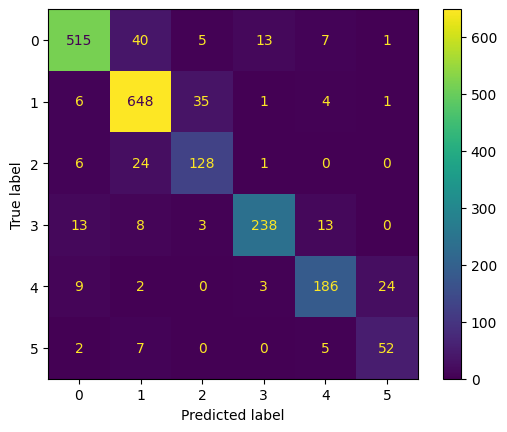

In [ ]:
print(Counter(y_pred))
ConfusionMatrixDisplay.from_predictions(labels_test, y_pred)


plt.show()